# Exercise 2

The data reported in `ESE7_ex2.csv` refer to temperature measurements in a chemical process, one measure per minute (Time Series Analysis: Forecasting and Control Box, Jenkins e Reinsel 1994). 

1. Design a traditional control chart for the process data. 
2. Identify a suitable model for the process data.
3. By using the identified model, design both SCC and FVC charts; compare the results with those achieved at point 1.

> Let's start by importing the required libraries and loading the data.

In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import qda

# Import the dataset
data = pd.read_csv('ESE7_ex2.csv')

# Inspect the dataset
data.head()

,temp
0,200
1,202
2,208
3,204
4,204


## Point 1

Design a traditional control chart for the process data.

> ### Solution
> Let’s design a control chart in a BLIND way, i.e., without checking the assumptions and without any graphical analysis of process data (**wrong approach**).

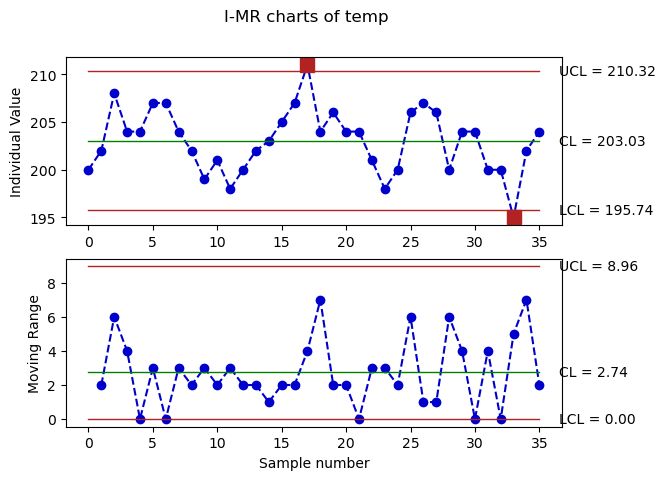

In [2]:
df_IMR = qda.ControlCharts.IMR(data, 'temp')

> Two observations are out of control. 

> Is this result trustworthy?
> **NO**, unless assumptions are verified.

> Perform the runs test to check if the data are random. Use the `runstest_1samp` function from the `statsmodels` package.

In [3]:
# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(data['temp'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

Runs test p-value = 0.002


> Plot the autocorrelation and partial autocorrelation functions of the data. Use the `plot_acf` and `plot_pacf` functions from the `statsmodels` package.

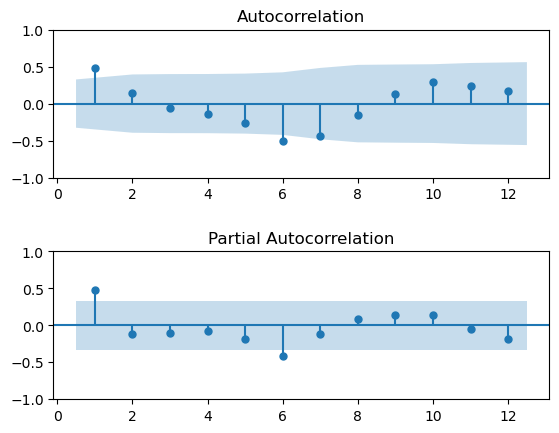

In [4]:
# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(data['temp'], lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(data['temp'], lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

> Data are nonrandom and the autocorrelation function shows a significant autocorrelation at lag 1. 

## Point 2

Identify a suitable model for the process data.

> ### Solution
> Let’s try to fit a AR(1) model to the data. 

In [5]:
# Add a column with the lagged temperature to use as regressor
data['temp_lag1'] = data['temp'].shift(1)

# Fit the linear regression model
import statsmodels.api as sm

x = data['temp_lag1'][1:]
x = sm.add_constant(x) # this command is used to consider a constant to the model, is equivalent to create and add a column of ones
y = data['temp'][1:]
model = sm.OLS(y, x).fit()
qda.summary(model)

REGRESSION EQUATION
-------------------
temp =  + 105.800 const + 0.479 temp_lag1

COEFFICIENTS
------------
     Term     Coef  SE Coef  T-Value  P-Value
    const 105.7999  30.5748   3.4604   0.0015
temp_lag1   0.4794   0.1506   3.1833   0.0032

MODEL SUMMARY
-------------
     S   R-sq  R-sq(adj)
2.9664 0.2349     0.2117

ANALYSIS OF VARIANCE
---------------------
    Source   DF   Adj SS   Adj MS  F-Value  P-Value
Regression  1.0  89.1649  89.1649  10.1332   0.0032
     const  1.0 105.3642 105.3642  11.9741   0.0015
 temp_lag1  1.0  89.1649  89.1649  10.1332   0.0032
     Error 33.0 290.3779   8.7993      NaN      NaN
     Total 34.0 379.5429      NaN      NaN      NaN


> Now check the residuals of the AR(1) model. 

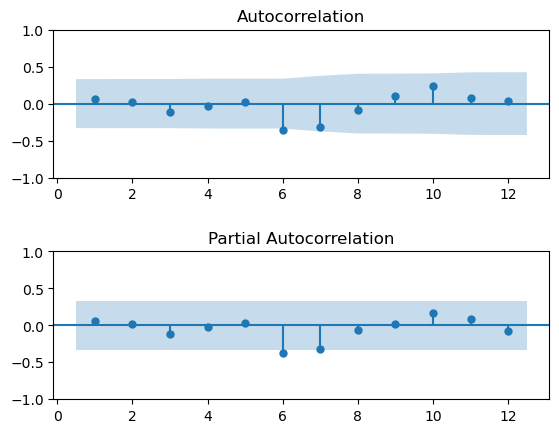

In [6]:
# Check the autocorrelation of the residuals
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(model.resid, lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(model.resid, lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

In [7]:
_, pval_runs_resid = runstest_1samp(model.resid, correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs_resid))

Runs test p-value = 0.244


Shapiro-Wilk test p-value on the residuals = 0.954


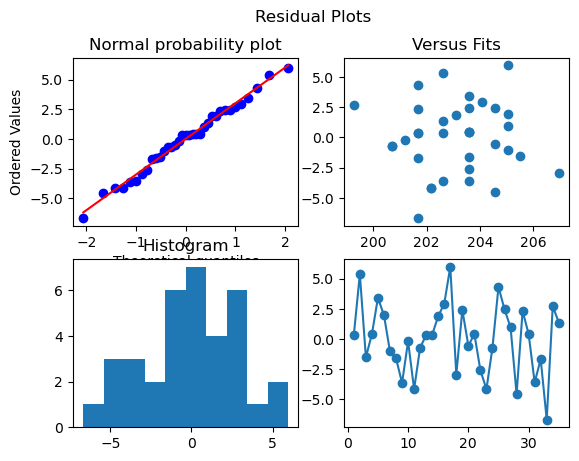

In [8]:
# Plot the residuals and test for normality
fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')
stats.probplot(model.resid, dist="norm", plot=axs[0,0])
axs[0,0].set_title('Normal probability plot')
axs[0,1].scatter(model.fittedvalues, model.resid)
axs[0,1].set_title('Versus Fits')
axs[1,0].hist(model.resid)
axs[1,0].set_title('Histogram')
axs[1,1].plot(np.arange(1, len(model.resid)+1), model.resid, 'o-')
_, pval_SW_res = stats.shapiro(model.resid)
print('Shapiro-Wilk test p-value on the residuals = %.3f' % pval_SW_res)

> All assumptions are verified.

## Point 3

By using the identified model, design both SCC and FVC charts; compare the results with those achieved at point 1.

> ### Solution
> Let’s design a SCC chart for the AR(1) model.

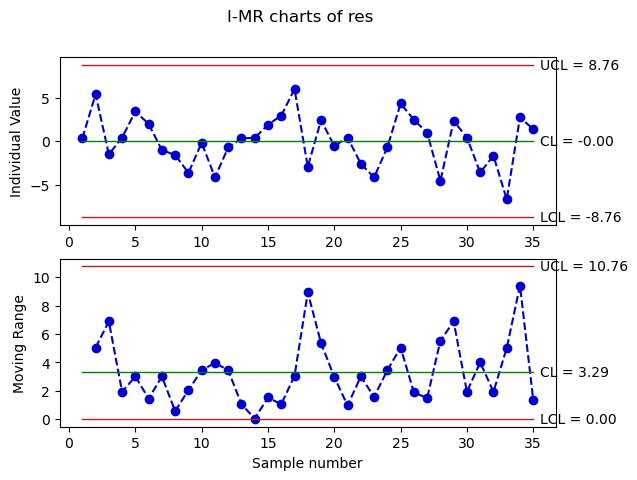

In [9]:
# Put the residuals in a dataframe
df_SCC = pd.DataFrame(model.resid, columns=['res'])

# Plot the IMR control chart
df_SCC_IMR = qda.ControlCharts.IMR(df_SCC, 'res')

> Notice that the MR of residuals is significantly different from the MR of original observations. Thus, the approximation that is usable for TREND models is not applicable to AR(1) models. 

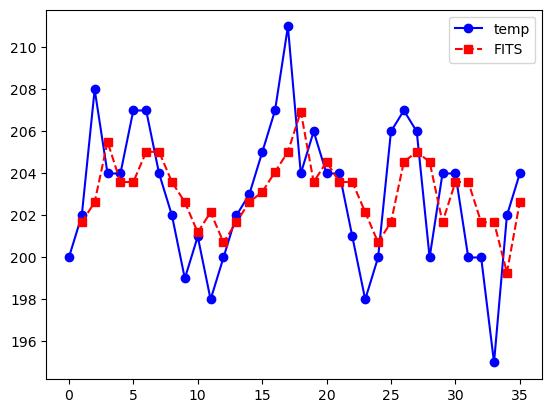

In [14]:
plt.plot(data['temp'], color='b', linestyle='-', marker='o', label='temp')
plt.plot(model.fittedvalues, color='r', linestyle='--', marker='s', label='FITS')
plt.legend()
plt.show()

Also in this case (in analogy with the TREND control chart) we can design a model-based CC as follows.

In [17]:
d2 = qda.constants.getd2(2)

MRbar_res = df_SCC_IMR['MR_CL'].iloc[0]

In [19]:
# Create a new dataframe with the original data and the center line (the fitted values)
df = pd.DataFrame({'I': data['temp'].iloc[1:], 'I_CL': model.fittedvalues}, index=data.index[1:])

# Add the I_UCL and I_LCL columns with the upper and 
# lower control limits computed from the formula
df['I_UCL'] = df['I_CL'] + 3 * MRbar_res / d2
df['I_LCL'] = df['I_CL'] - 3 * MRbar_res / d2

# Add the TEST1 column
df['I_TEST1'] = np.where((df['I'] > df['I_UCL']) | (df['I'] < df['I_LCL']), df['I'], np.nan)


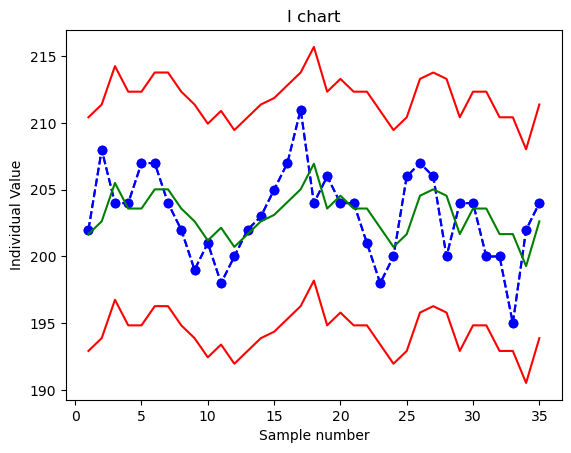

In [20]:
# Plot the I chart
plt.title('I chart')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I_UCL'], color='r')
plt.plot(df['I_CL'], color='g')
plt.plot(df['I_LCL'], color='r')
plt.ylabel('Individual Value')
plt.xlabel('Sample number')
# highlight the points that violate the alarm rules
plt.plot(df['I_TEST1'], linestyle='none', marker='s', 
        color='r', markersize=10)

plt.show()

> We may conclude that no out-of-control data are present, but the trend pattern between observation 12 and 18 might be investigated more in depth.